In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from utils import load_mnist
from trainer import Trainer

In [4]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)

print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [5]:
# reconstruction 확인
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)
    
    plt.imshow(x, cmap='gray')
    plt.show()

In [6]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio) # train_x = |x| = (batch_size, 784)
valid_cnt = train_x.size(0) - train_cnt

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0)) # randperm - for shuffling - 랜덤한 수열을 생성
train_x, valid_x = torch.index_select( # index_select - indices에 따라 index 조정
    train_x,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)
train_y, valid_y = torch.index_select(
    train_y,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [7]:
from model import Autoencoder

In [8]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [9]:
# train_x를 넣으면 train_x를 복원하도록, valid_x를 넣으면 valid_x를 복원하도록
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=7.2033e-02  valid_loss=5.0033e-02  lowest_loss=5.0033e-02
Epoch(2/50): train_loss=4.7503e-02  valid_loss=4.4709e-02  lowest_loss=4.4709e-02
Epoch(3/50): train_loss=4.4758e-02  valid_loss=4.2861e-02  lowest_loss=4.2861e-02
Epoch(4/50): train_loss=4.3379e-02  valid_loss=4.3112e-02  lowest_loss=4.2861e-02
Epoch(5/50): train_loss=4.2550e-02  valid_loss=4.1273e-02  lowest_loss=4.1273e-02
Epoch(6/50): train_loss=4.1644e-02  valid_loss=4.0086e-02  lowest_loss=4.0086e-02
Epoch(7/50): train_loss=4.1633e-02  valid_loss=4.0123e-02  lowest_loss=4.0086e-02
Epoch(8/50): train_loss=4.1135e-02  valid_loss=3.9418e-02  lowest_loss=3.9418e-02
Epoch(9/50): train_loss=4.0644e-02  valid_loss=3.9556e-02  lowest_loss=3.9418e-02
Epoch(10/50): train_loss=4.0242e-02  valid_loss=3.9303e-02  lowest_loss=3.9303e-02
Epoch(11/50): train_loss=3.9973e-02  valid_loss=3.8907e-02  lowest_loss=3.8907e-02
Epoch(12/50): train_loss=3.9768e-02  valid_loss=3.8344e-02  lowest_loss=3.8344e-02
Epoch(13/50):

## Test

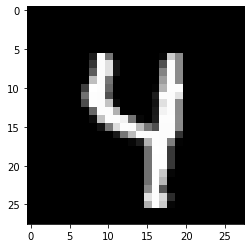

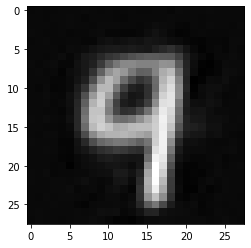

In [10]:
with torch.no_grad():
    import random

    index = int(random.random() * test_x.size(0))

    recon = model(test_x[index].view(1, -1)).squeeze()
    # |test_x| = (10000,784)
    # |test_x[index]| = (784,)
    # |test_x[index].view(1, -1)| = (1(batch_size),784)
    # |model(~)| = (1,784)-> (784,)
    show_image(test_x[index])
    show_image(recon)

- 시각화를 위해서 2차원으로 설정
- btl_size = 2(2차원)이기에 너무 많은 정보를 압축하고 있음
- 10정도로 btl_size를 설정하고, epoch를 늘리면 성능향상을 기대할 수 있음

## Latent Space

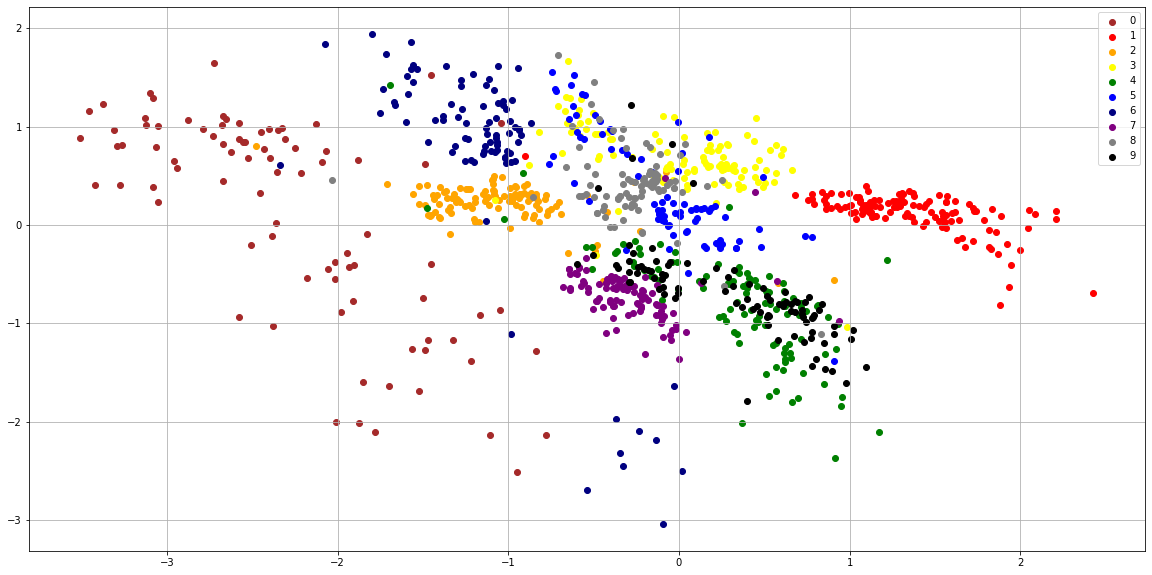

In [11]:
if config.btl_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black',
    ]
    
    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latents = latents[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            plt.scatter(target_latents[:, 0],
                        target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        label=i)
        
        plt.legend()
        plt.grid(axis='both')
        plt.show()

- |latent| = (1000,2)
- 비슷한 특성을 지닌 이미지끼리, 같이 모이는 모습을 볼 수 있음
- 4와 9가 비슷하게 생겨서, 4와 9가 모이는 모습을 보임

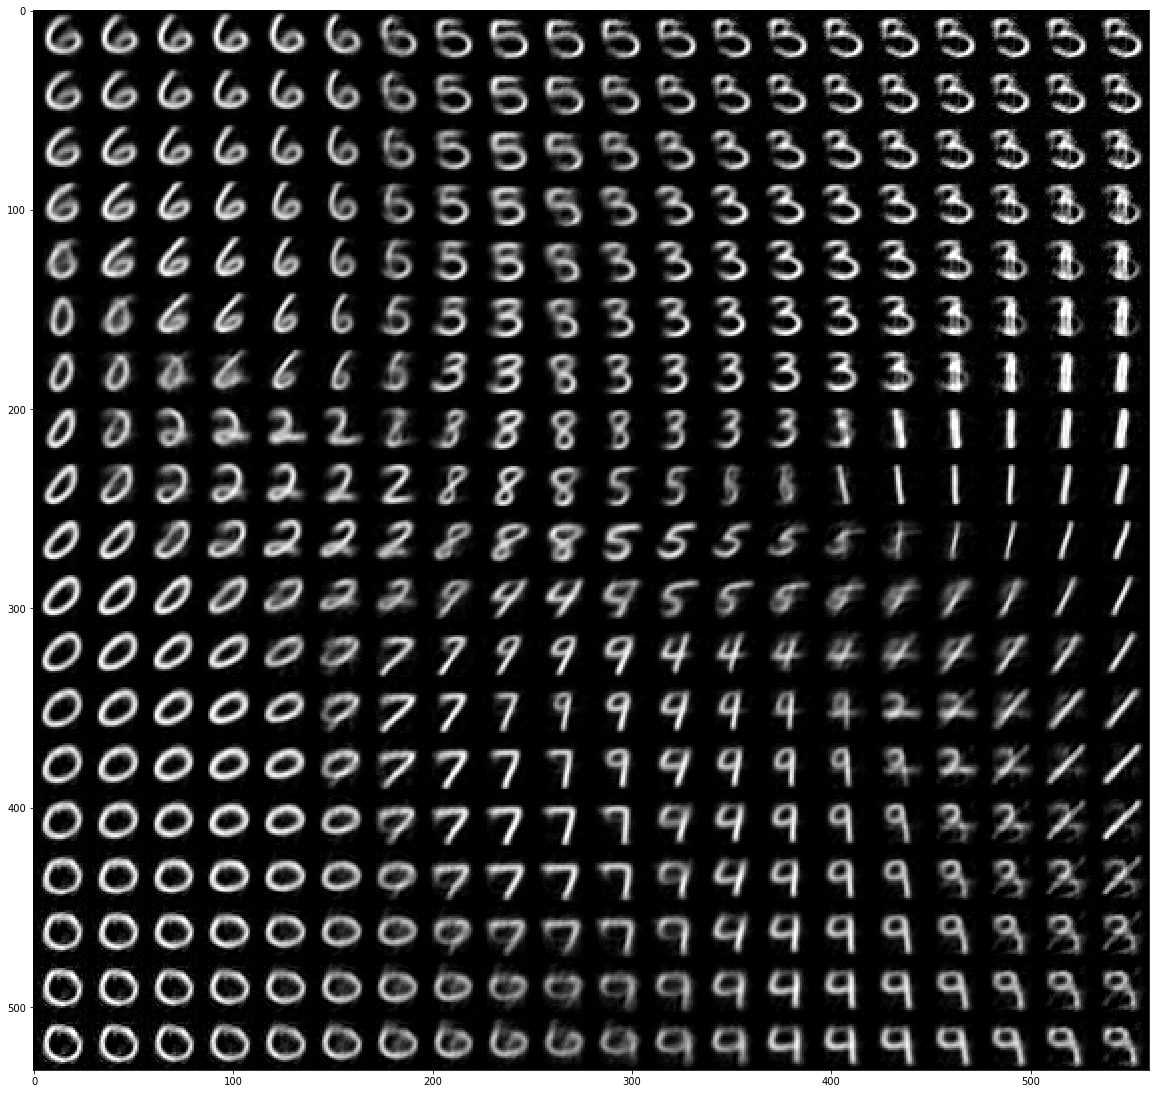

In [12]:
if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range, step)]),
                # |v1| = -2
                # [-2,...,-2] - 20개
                # v2
                # [-2. -1.8, ..., -1.8] - 20개
                # |z| = (20,2)
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            # |decoder(z)| = (20,784)
            # |decoder(z).view(n, 28, 28)| = (20,28,28)
            # |line| = (28,28)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            # 거꾸로 쌓는 과정,-2 ~ 2까지 거꾸로 샘플링했기 때문 
            # 한 줄로 펴는 과정
            # |line| = (28*20,28) * n=20
            lines += [line]
            # |lines| = (28*20,28*20)
            
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)